In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import pandas as pd
import geopandas as gpd
import xgboost
import sys
from sklearn.preprocessing import LabelEncoder
import numpy as np
from math import * 
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN, OPTICS
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.style.use('dark_background')

from utils import plot_cluster, load_list, save_list, load_data, load_data_test


In [244]:
X, Y = load_data(add_knn_mean=True,
                 add_knn_concat=False,
                 add_polynomial=False,
                 n_data_max=99999999,
                 shuffle = True)

# X_target = load_data_test(add_knn_mean=True,
#                  add_knn_concat=False,
#                  n_data_max=99999999,
#                  shuffle = False)

X[X.isna().any(axis = 1)]


Loading data...


c:\Users\timot\MLcompetition\utils.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Y = train_df["change_type"].reindex(idx)[:n_data_max]


(309871, 93)
X_train and Y_train loaded.


,change_status_date1,change_status_date2,change_status_date3,change_status_date4,change_status_date5,diff1,diff2,diff3,diff4,season_date1,...,knn_mean_year_date1,knn_mean_year_date2,knn_mean_year_date3,knn_mean_year_date4,knn_mean_year_date5,knn_mean_season_date1,knn_mean_season_date2,knn_mean_season_date3,knn_mean_season_date4,knn_mean_season_date5
12761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2014.0,2015.0,2017.0,2019.0,2020.0,3.0,3.0,3.0,3.0,3.0
17961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2015.0,2017.0,2018.0,2019.0,2020.0,3.0,3.0,3.0,3.0,3.0
22612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2014.0,2015.0,2017.0,2018.0,2019.0,3.0,3.0,3.0,3.0,3.0
24579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2013.0,2015.0,2017.0,2018.0,2019.0,3.0,3.0,3.0,3.0,3.0
24651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2013.0,2015.0,2017.0,2018.0,2019.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309866,4.0,5.0,5.0,0.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309867,9.0,9.0,1.0,0.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309868,9.0,4.0,4.0,0.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309869,9.0,9.0,9.0,1.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
Y.shape

(309000,)

,change_status_date1,change_status_date2,change_status_date3,change_status_date4,change_status_date5,diff1,diff2,diff3,diff4,season_date1,...,knn_mean_year_date1,knn_mean_year_date2,knn_mean_year_date3,knn_mean_year_date4,knn_mean_year_date5,knn_mean_season_date1,knn_mean_season_date2,knn_mean_season_date3,knn_mean_season_date4,knn_mean_season_date5
12761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2014.0,2015.0,2017.0,2019.0,2020.0,3.0,3.0,3.0,3.0,3.0
17961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2015.0,2017.0,2018.0,2019.0,2020.0,3.0,3.0,3.0,3.0,3.0
22612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2014.0,2015.0,2017.0,2018.0,2019.0,3.0,3.0,3.0,3.0,3.0
24579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2013.0,2015.0,2017.0,2018.0,2019.0,3.0,3.0,3.0,3.0,3.0
24651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2013.0,2015.0,2017.0,2018.0,2019.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309130,9.0,9.0,9.0,0.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309131,5.0,1.0,1.0,0.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309132,5.0,1.0,1.0,1.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309133,1.0,0.0,0.0,0.0,0.0,346.0,974.0,438.0,464.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:

# xgb = XGBClassifier()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)

print('Fitting...')
L_n = [200, 300, 50, 100]
L_d = [2, 3, 4, 5, 10]
L_n = [120]
average = 'weighted'
L_train_score = list()
L_test_score = list()
L = list()

for n in L_n:
        model = RandomForestClassifier(n_estimators=n,
                            max_depth=8,
                            min_samples_leaf=1,
                            min_samples_split=2,
                                )
        # model = GradientBoostingClassifier(n_estimators=n, 
        #                         )
        # model = XGBClassifier( 
        #                 n_estimators = n,
        #         #       scale_pos_weight=1,
        #         #       learning_rate=0.01,  
        #         #       colsample_bytree = 0.4,
        #         #       subsample = 0.8,
        #         #       objective='binary:logistic', 
        #         #       reg_alpha = 0.3,
        #         #       max_depth=4, 
        #         #       gamma=10,
        #                 use_label_encoder=False,
        #               )
        
        eval_set = [(X_train, Y_train), (X_test, Y_test)]
        eval_metric = ["error"]
        model.fit(X_train, Y_train, 
                # eval_metric=eval_metric, 
                # eval_set=eval_set, 
                # verbose=False
                  )
        
        Y_pred          = model.predict(X_test)
        Y_pred_train    = model.predict(X_train)
        score_train = f1_score(Y_train, Y_pred_train, average = average)
        score_test = f1_score(Y_test, Y_pred, average = average)
        L_train_score.append(score_train)
        L_test_score.append(score_test)
        L.append(n)
        print(f"Train score: {score_train}")
        print(f"Test score: {score_test}")
        print()
        plt.clf()
        plt.plot(L, L_train_score, 'r')
        plt.plot(L, L_test_score, 'b')
        plt.ylim(bottom = 0, top = 1)



Fitting...


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [171]:
importances = model.feature_importances_
for feature, imp in zip(X_train.columns, importances):
    print(f'Importance of {feature}: {100*round(imp, 3)}%')

Importance of change_status_date1: 7.3999999999999995%
Importance of change_status_date2: 4.3%
Importance of change_status_date3: 3.3000000000000003%
Importance of change_status_date4: 5.6000000000000005%
Importance of change_status_date5: 16.7%
Importance of diff1: 1.0%
Importance of diff2: 1.5%
Importance of diff3: 1.6%
Importance of diff4: 1.0999999999999999%
Importance of season_date1: 0.0%
Importance of season_date2: 0.0%
Importance of season_date3: 0.0%
Importance of season_date4: 0.0%
Importance of season_date5: 0.0%
Importance of year_date1: 1.9%
Importance of year_date2: 1.7999999999999998%
Importance of year_date3: 0.4%
Importance of year_date4: 0.4%
Importance of year_date5: 0.4%
Importance of area: 0.0%
Importance of length: 5.800000000000001%
Importance of area/length**2: 6.0%
Importance of elongation: 1.0999999999999999%
Importance of centroid_x: 9.2%
Importance of centroid_y: 13.8%
Importance of height: 4.5%
Importance of width: 3.5000000000000004%
Importance of nb_point

In [15]:
Y_pred2submit = model.predict(X_target)

# Save results to submission file
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission.csv", index=True, index_label='Id')

In [33]:
test_df_origin = gpd.read_file("test.geojson", index_col=0) 

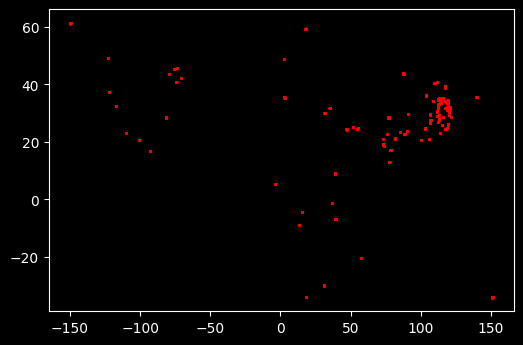

In [119]:
plot_cluster(X)

In [118]:
def compress_outliers_on_test(X):
    X[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30
    return X